In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string

# VEST NE 2020

### Races

G20PRERTRU - Donald J. Trump (Republican Party)<br>
G20PREDBID - Joseph R. Biden (Democratic Party)<br>
G20PRELJOR - Jo Jorgensen (Libertarian Party)<br>
G20USSRSAS - Ben Sasse (Republican Party)<br>
G20USSDJAN - Chris Janicek (Democratic Party)<br>
G20USSLSIA - Gene Siadek (Libertarian Party)<br>

## Load in VEST file

In [2]:
vest_ne_2020 = gp.read_file("../vest/ne_2020/ne_2020.shp")

In [3]:
vest_ne_2020

,COUNTY,NAME,G20PRERTRU,G20PREDBID,G20PRELJOR,G20USSRSAS,G20USSDJAN,G20USSLSIA,geometry
0,057,Benkelman I/Ough,332,51,3,308,43,20,"POLYGON Z ((-101.75951 40.34963 0.00000, -101...."
1,057,Benkelman II,295,23,5,281,15,14,"POLYGON Z ((-101.54990 40.09466 0.00000, -101...."
2,057,Benkelman III,147,14,0,136,9,7,"POLYGON Z ((-101.89239 40.34937 0.00000, -101...."
3,057,Haigler,109,17,3,110,10,7,"POLYGON Z ((-102.05197 40.14835 0.00000, -102...."
4,017,City of Ainsworth Precinct,707,101,14,675,68,47,"POLYGON Z ((-99.87398 42.54692 0.00000, -99.87..."
...,...,...,...,...,...,...,...,...,...
1381,055,01-31,538,834,18,642,467,67,"POLYGON Z ((-95.99285 41.34651 0.00000, -95.99..."
1382,055,08-12,736,938,47,833,604,104,"MULTIPOLYGON Z (((-96.04777 41.33416 0.00000, ..."
1383,055,07-35,564,658,26,657,402,51,"POLYGON Z ((-96.14410 41.30250 0.00000, -96.14..."
1384,055,08-13,1102,434,24,1165,239,78,"POLYGON Z ((-96.10087 41.38958 0.00000, -96.10..."


<AxesSubplot:>

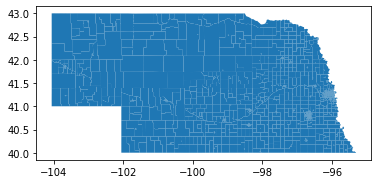

In [4]:
vest_ne_2020.plot()

In [ ]:
vest_ne_2020.plot()

### Load in Raw Election Results

In [5]:
er_2020_df = pd.read_csv('../raw-data/2020/20201103__ne__general__precinct.csv')

In [6]:
er_2020_df

,county,precinct,office,district,party,candidate,votes
0,Buffalo,Precinct 1,State House,37.0,NaN,John S. Lowe Sr.,722.0
1,Buffalo,Precinct 1,State House,37.0,NaN,Mercadies Damratowski,173.0
2,Buffalo,Precinct 2,State House,37.0,NaN,John S. Lowe Sr.,523.0
3,Buffalo,Precinct 2,State House,37.0,NaN,Mercadies Damratowski,211.0
4,Buffalo,Precinct 3,State House,37.0,NaN,John S. Lowe Sr.,813.0
...,...,...,...,...,...,...,...
12817,Douglas,08~60,State House,7.0,NaN,Jorge Sotolongo,0.0
12818,Douglas,08~61,State House,7.0,NaN,Tony Vargas,0.0
12819,Douglas,08~61,State House,7.0,NaN,Jorge Sotolongo,0.0
12820,Douglas,Countywide,State House,7.0,NaN,Tony Vargas,0.0
